In [1]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [2]:
### 读取数据
dataset = pd.read_csv('C:/Users/Yan3/Desktop/dataset/pm2.5/pollution.csv')
dataset.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


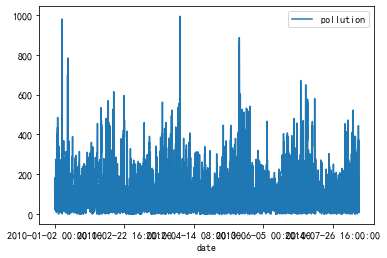

In [3]:
### 先画一个污染随时间的变化图
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
dataset.plot(x='date', y = 'pollution')

In [4]:
df = dataset[['date','pollution']].copy()
df.date = pd.to_datetime(df.date)
df.index = df.date

                                   date  pollution
date                                              
2010-01-02 00:00:00 2010-01-02 00:00:00      129.0
2010-01-02 01:00:00 2010-01-02 01:00:00      148.0
2010-01-02 02:00:00 2010-01-02 02:00:00      159.0
2010-01-02 03:00:00 2010-01-02 03:00:00      181.0
2010-01-02 04:00:00 2010-01-02 04:00:00      138.0
             pollution
date                  
2010-01-31   82.026389
2010-02-28   97.089286
2010-03-31   89.673387
2010-04-30   79.806944
2010-05-31   86.081989
2010-06-30   85.537500
2010-07-31  123.647849
2010-08-31   88.681452
2010-09-30   79.631944
2010-10-31  118.662634
2010-11-30  127.377778
2010-12-31   97.333333
2011-01-31   40.547043
2011-02-28  150.321429
2011-03-31   48.654570
2011-04-30   68.180556
2011-05-31   62.512097
2011-06-30  107.111111
2011-07-31  107.138441
2011-08-31   79.236559
2011-09-30   95.140278
2011-10-31  120.240591
2011-11-30  108.870833
2011-12-31  108.373656
2012-01-31  107.443548
2012-02-29   83.272989

C:\Users\Yan3\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


最优模型:                                 SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                   60
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -255.583
Date:                Fri, 01 Jan 2021   AIC                            525.165
Time:                        04:30:48   BIC                            539.088
Sample:                    01-31-2010   HQIC                           530.535
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0552      0.093     -0.591      0.555      -0.238       0.128
ar.L2         -0.9089      0.110     -8.284      0.000      -1.124      -0.694
ma.L1         -0.7913    894.453     -0.001  

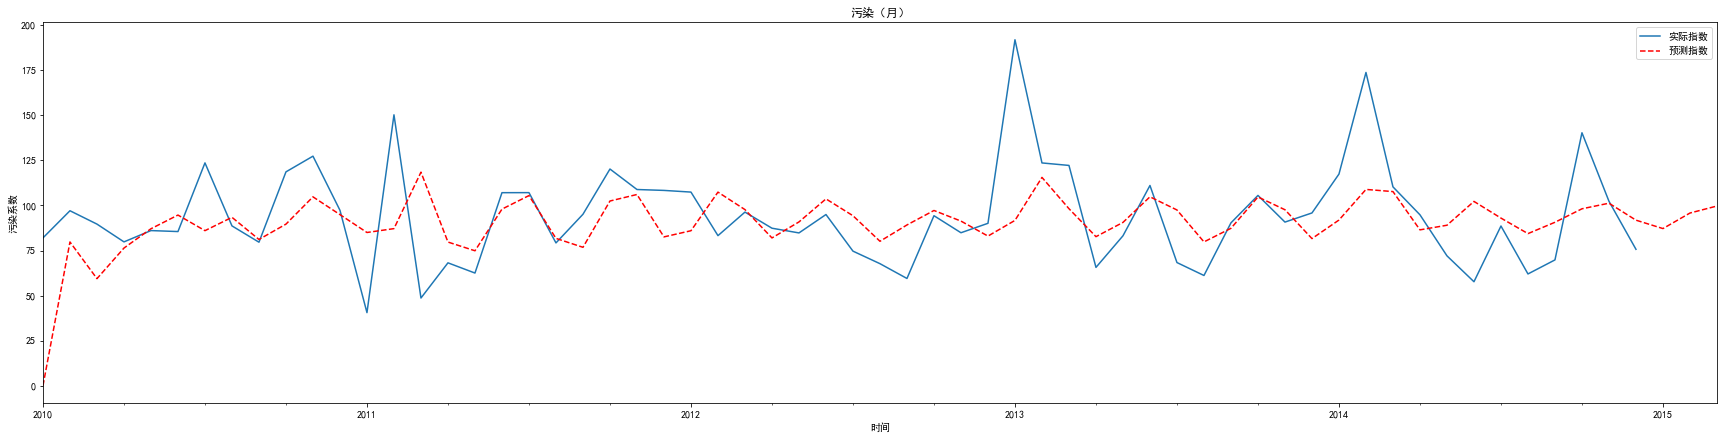

In [5]:
print(df.head())
# 按照天，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()
print(df_month)

# 设置参数范围
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.pollution,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df_month.pollution,
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['pollution']]
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

# get_prediction得到的是区间，使用predicted_mean
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean

# 污染指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.pollution.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('污染（月）')
plt.xlabel('时间')
plt.ylabel('污染系数')
plt.show()